# Simple Code BLock Recognition Example

This notebook is a (work in progress) simple example that conists of every processing part in the code block recognition and syntax tree generation process.

Starting from an 'easy' example image I intend to create a pre-processing process that will give me reliable results. When that is done i will enlarge my image set and further improve each individual processing part.

## Binarization 

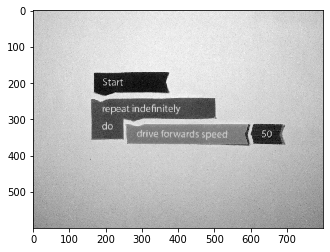

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
import os
from PIL import Image
from scipy.ndimage import label
from scipy.ndimage import binary_closing


A = np.array(Image.open('test_images/new.jpg'))
A = cv.resize(A, dsize=(800, 600), interpolation=cv.INTER_CUBIC)
A_gray = cv.cvtColor(A, cv.COLOR_BGR2GRAY)
plt.imshow(A_gray, cmap='gray')
plt.show()

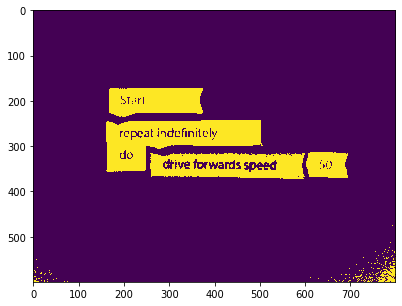

In [10]:
ret, A_bin = cv.threshold(A_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
A_bin = np.invert(A_bin)
plt.figure(figsize=(15, 5))
plt.imshow(A_bin)
plt.show()

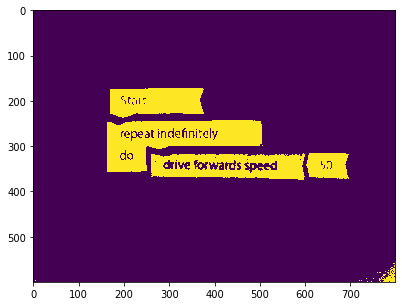

In [11]:
x = 2
kernel = cv.getStructuringElement(cv.MORPH_RECT,(x,x))
opening = cv.morphologyEx(A_bin, cv.MORPH_OPEN, kernel)

plt.figure(figsize=(15,5))
plt.imshow(opening)
plt.show()

## Connected components - Seperating code blocks from initial tangible program

Low pixel filter 1440.0 High pixel filter 144000.0
Initial components: 48
Number of selected components: 4


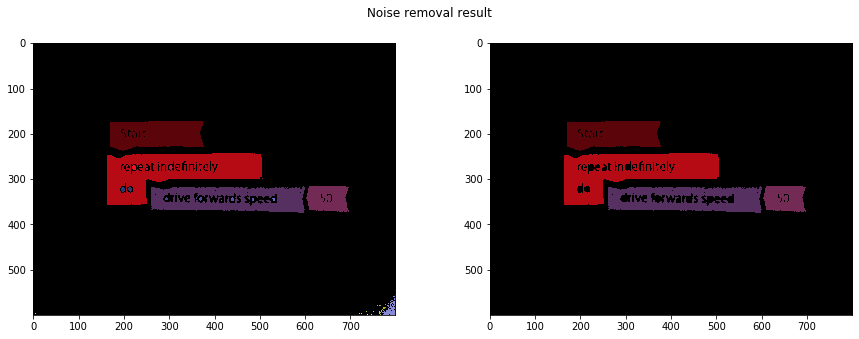

In [12]:
def filter_features(binary):
    features_list = label(binary)
    connected_components = features_list[0]
    processed_result = np.copy(connected_components)
    # remove a feature if it covers over 30% of the image or les than 0.03%
    low_filter = .003*np.prod(connected_components.shape)
    high_filter = .3*np.prod(connected_components.shape)
    print('Low pixel filter {} High pixel filter {}'.format(low_filter, high_filter))
    print('Initial components: {}'.format(features_list[1]))
    components = 0
    for feature in range(features_list[1]):
        if((np.count_nonzero(connected_components == feature) < low_filter) or (np.count_nonzero(connected_components == feature) > high_filter)):
            processed_result[connected_components == feature] = 0
            continue
        components += 1
        #print(np.count_nonzero(css == i))
    print('Number of selected components: {}'.format(components))
    return processed_result, connected_components


res, cc = filter_features(opening)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Noise removal result')
ax1.imshow(cc, cmap='gist_stern')
ax2.imshow(res, cmap='gist_stern')
fig.show()

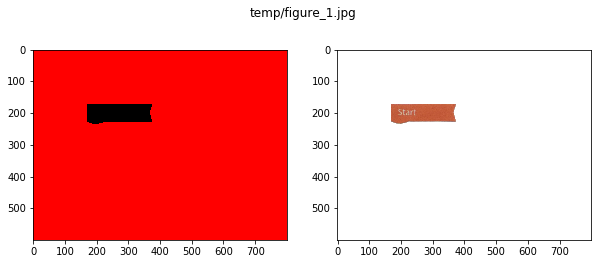

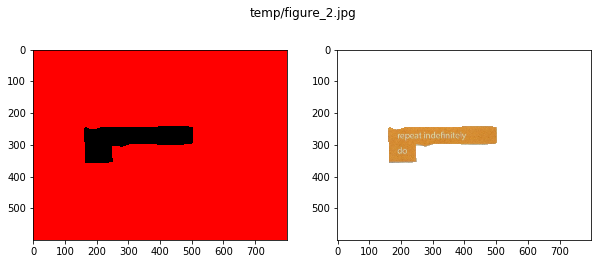

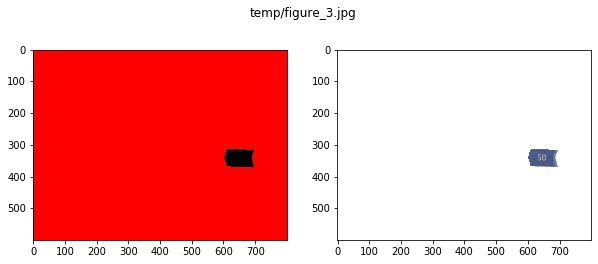

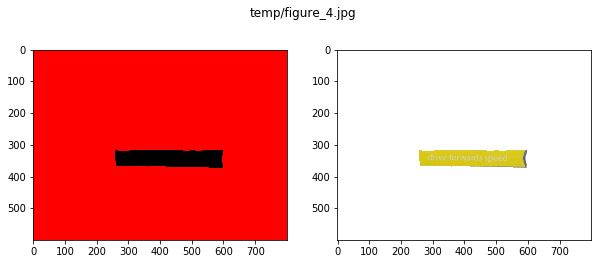

In [13]:
def fill_letters(segmentation, initial_image):
    low_filter = .003*np.prod(segmentation.shape)
    high_filter = .3*np.prod(segmentation.shape)
    window_size = 14 # crusial
    res = np.copy(segmentation)
    number = 0
    for part in range(np.max(segmentation)):
        A = (segmentation == part)
        # closing to each block
        B = binary_closing(A, structure=np.ones((window_size ,  window_size)))
        if(np.count_nonzero(B) < low_filter or np.count_nonzero(B) > high_filter):
            continue
        number += 1
        input_masked = np.copy(initial_image)
        input_masked[B == False] = 255

        filename = 'temp/figure_{}.jpg'.format(number)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(filename)
        ax1.imshow(B, cmap='flag')
        ax2.imshow(input_masked, cmap='flag')
        fig.show()   
        figure = Image.fromarray(input_masked)
        figure.save(filename) 
    return(number)

number = fill_letters(res, A)

## Color masking pre-process for Tesseract OCR

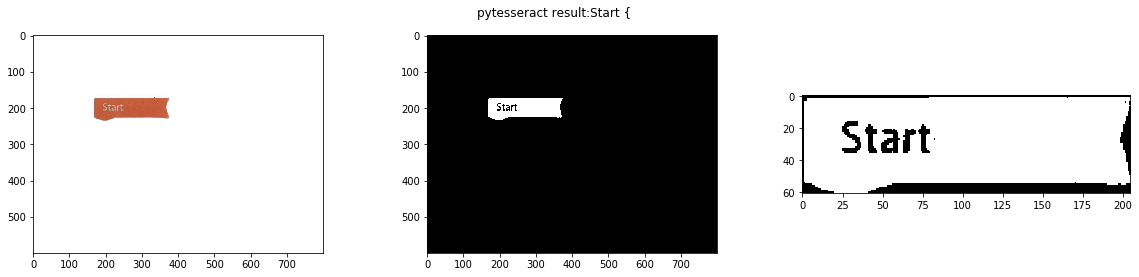

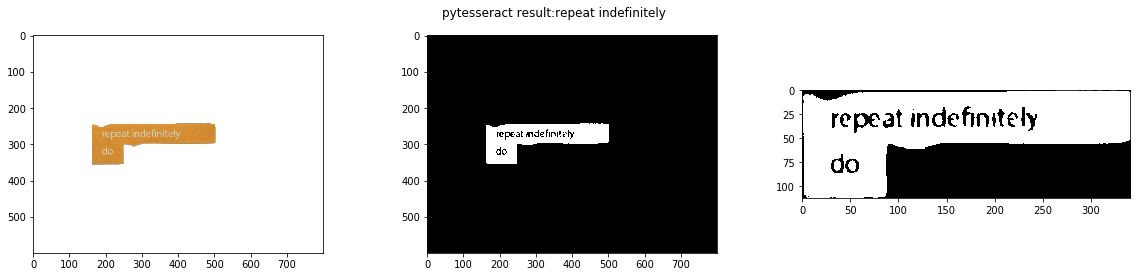

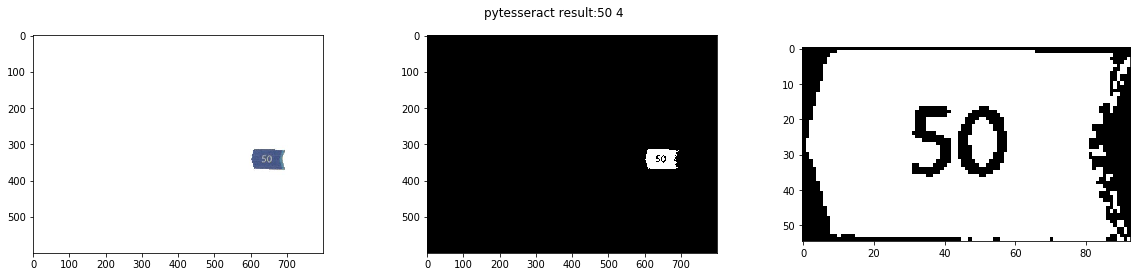

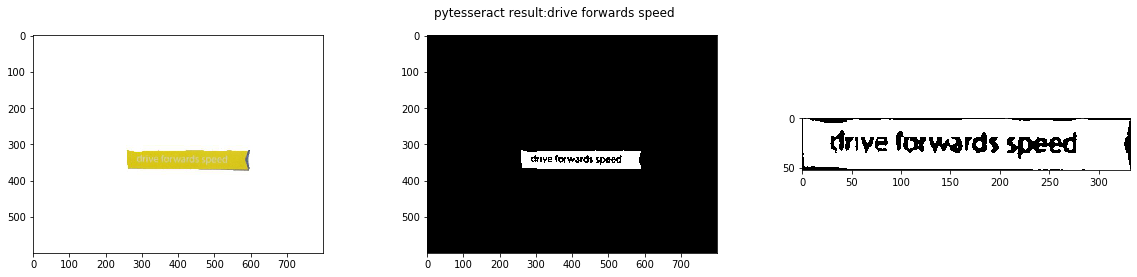

In [14]:
temp_directory = '/home/vasilisp/Desktop/tangibles-recognition/temp/'

RED = 1
ORANGE = 2
BLUE = 3
YELLOW = 4 
WHITE = 5 

color_dict = { RED    : np.array([195, 72, 97]),
               ORANGE : np.array([213, 143, 54]),
               BLUE   : np.array([67, 85, 133]), 
               YELLOW : np.array([215, 202, 21]),   
               WHITE  : np.array([191, 189, 174])}

color_dict_size = 4 # change this 

def get_color_thresholds(color_name):
    c = color_dict[color_name]
    l_threshold = u_threshold = 50
    lower = np.array([c[0] - l_threshold, c[1] - l_threshold, c[2] - l_threshold]) 
    upper = np.array([c[0] + u_threshold, c[1] + u_threshold, c[2] + u_threshold])
    return upper, lower

result =  np.copy(A)
for i in range(1, color_dict_size+1):
    figure = np.array(Image.open(temp_directory+'figure_'+str(i)+'.jpg'))
    upper, lower = get_color_thresholds(i)
    mask = cv.inRange(figure, lower, upper)

    canny = cv.Canny(mask, 0, 0)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped = mask[y1:y2, x1:x2]

    result = cv.rectangle(result, (x1, y1), (x2, y2), (36,255,12), 1)
    text_in_block = pytesseract.image_to_string(cropped, lang='eng')
    cv.putText(result, text_in_block, (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # planning on making a more sophisticated contains() method
    # for checking tesseracgt output 
    # if pre_guess in text_in_block:
    #    print('tesseract says:'+ pre_guess)


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    fig.suptitle('pytesseract result:'+text_in_block)
    ax1.imshow(figure)
    ax2.imshow(mask, cmap='gray')
    ax3.imshow(cropped, cmap='gray')
    fig.show()  

## Final Recognition Result

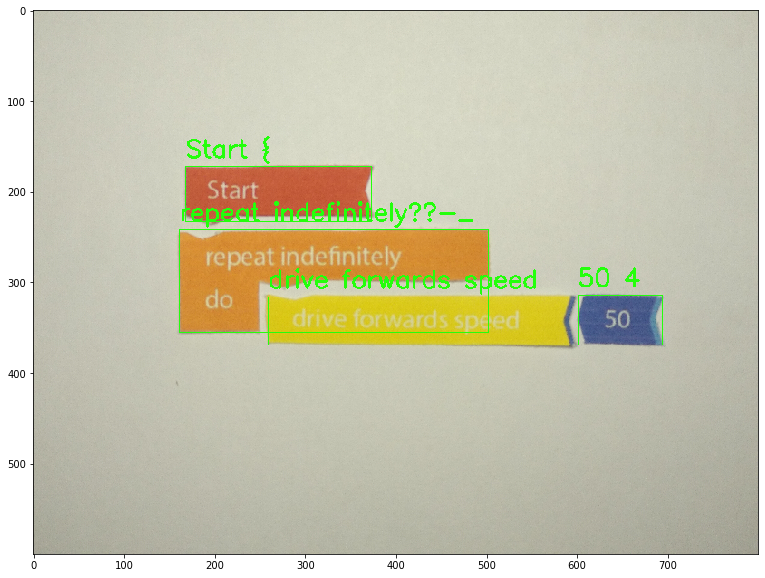

In [15]:
plt.figure(figsize=(15,10))
plt.imshow(result)
plt.show()

## Syntax Tree Generation 

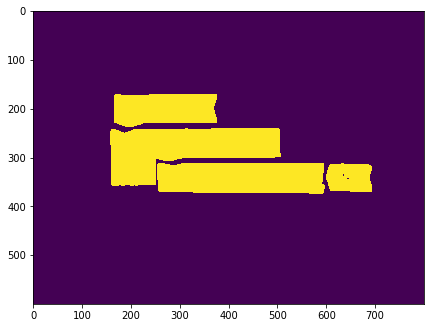

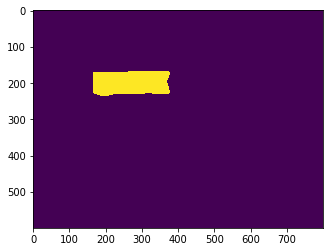

166 169


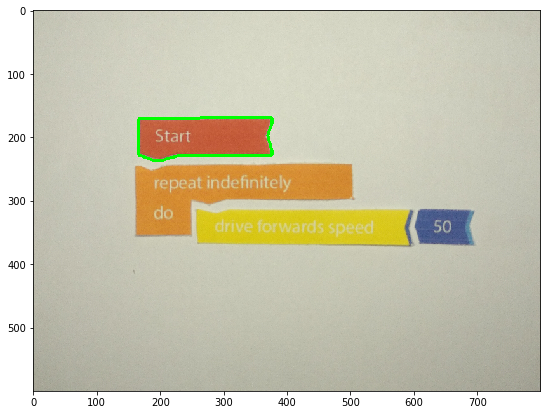

In [16]:
hsv_A = cv.cvtColor(A, cv.COLOR_RGB2HSV)
copy_A = np.copy(A)

h,s,v = cv.split(hsv_A)

ret3, th_saturation = cv.threshold(s, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
th_saturation = cv.dilate(th_saturation, kernel, iterations = 3)

plt.figure(figsize=(7,7))
plt.imshow(th_saturation)
plt.show()

num_labels, labels_im = cv.connectedComponents(th_saturation)


label = labels_im == 1

label_img = np.copy(th_saturation)
label_img[label == False] = 0
label_img[label == True] = 255

plt.imshow(label_img)
plt.show()

_, contours, _ = cv.findContours(label_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

x,y,w,h = cv.boundingRect(contours[0])
print(x, y)   
cv.drawContours(A, contours, -1, (0,255,0), 3)

plt.figure(figsize=(20,7))
plt.imshow(A)
plt.show()